# ENTREGABLE 3

Este entregable estudia la aplicabilidad del modelo de Debye al diamante con los datos de C.V. Raman (1957), en formato "Notebook" de Python. Importemos todas las librerías necesarias para nuestros cálculos. Debería de tardar como mucho unos $30\ \mathrm{s}$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import polynomial as poly
import scipy.constants as const
from scipy.integrate import quad_vec
from scipy.optimize import curve_fit, fsolve
plt.style.use(['science', 'grid', 'notebook'])

A continuación importemos los datos experimentales que se nos aportan y comprobemos que podemos leerlos.

In [2]:
datos = pd.read_csv('datos.dat', delimiter='\s+', header=None, dtype=float, names=['Temp', 'Cv'])
datos.head()

,Temp,Cv
0,12.7752,0.000091
1,15.9849,0.000197
2,18.4677,0.000244
3,19.6788,0.000304
4,21.1932,0.000387


### APARTADO 1

La ley de Debye a bajas temperaturas, régimen en el cual queremos ajustar $C_v$ frente a $T$, es la siguiente:

$$
C_v = 234R\left(\frac{T}{\Theta}\right)^3
$$

Realizaremos por tanto un ajuste lineal por mínimos cuadrados de $C_v$ frente a $T^3$, es decir:

$$
C_v = aT^3+b
$$

Con él podremos calcular la temperatura de Debye:

$$
\Theta = \sqrt[3]{\frac{234R}{a}}
$$

Al ajustar utilizaremos las incertidumbres en la medida de la capacidad calorífica presentadas por J.E. Desnoyers y J.A. Morrison (1958) para pesar los cuadrados de los residuos.

Text(0.05, 0.6, 'Cv = 2.94e-06 + 4.20e-08 T$^3$')

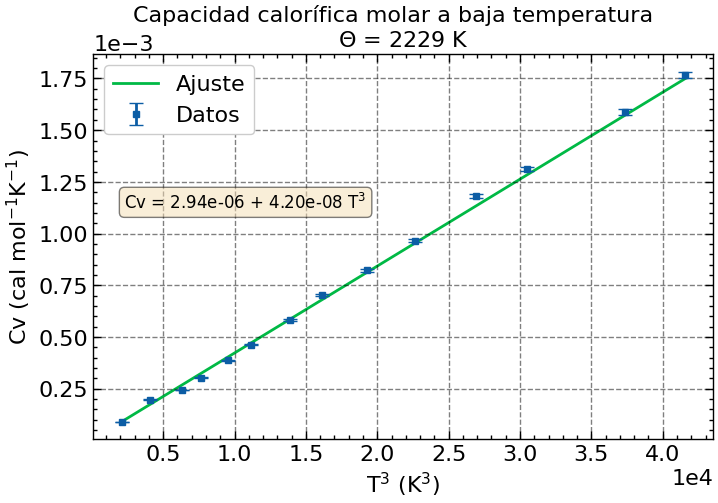

In [3]:
# Selección de datos
Tc = 35
T = datos.Temp[datos.Temp < Tc]
Cv = datos.Cv[datos.Temp < Tc]

# Incertidumbre
DCv = np.empty(len(datos.index))
DCv[datos.Temp < 20] = .2
DCv[datos.Temp < 100] = .06
DCv[datos.Temp < 200] = .008
DCv[datos.Temp > 200] = .002
DCv = DCv * datos.Cv

# Ajuste lineal
fit = poly.polyfit(T**3, Cv, deg=1, w=1/DCv[datos.Temp < Tc])

# Constante de los gases ideales [cal / mol K]
R = const.R / const.calorie

# Temperatura de Debye
theta = np.cbrt(234 * R / fit[1])

# Graficado
plt.figure(figsize=(8, 5))
plt.errorbar(T**3, Cv, yerr=DCv[datos.Temp < Tc], fmt='s', ms=4, capsize=5, label='Datos')
plt.plot(T**3, poly.polyval(T**3, fit), label='Ajuste', zorder=0)
plt.suptitle('Capacidad calorífica molar a baja temperatura', fontsize=16)
plt.title(f'$\Theta$ = {theta:.0f} K')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.xlabel('T$^3$ (K$^3$)')
plt.ylabel(r'Cv (cal mol$^{-1}$K$^{-1}$)')
plt.legend()
plt.text(
    .05, .6, 
    f'Cv = {fit[0]:.2e} + {fit[1]:.2e} T$^3$', 
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}
)

Comparando con la Tabla 2 de J.E. Desnoyers y J.A. Morrison (1958), vemos que nuestro cálculo es compatible con el suyo ($\Theta=2219^{+18}_{-17}\ \mathrm{K}$). No obtenemos exactamente el mismo $\Theta$ esperado, pero esto puede deberse a que ellos consideran contribuciones a $C_v$ de mayor orden en $T$. 

### APARTADO 2

Para calcular la capacidad calorífica $C_v(T)$ según el modelo de Debye, debemos realizar la integral correspondiente para cada valor de $T$. No obstante, no es conveniente calcularla en la forma en la que se nos presenta, con límites de integración variables. Será mejor calcular una integral parametrizada con límites fijos:

$$
\int_0^{\Theta/T} \frac{x^4 e^x}{(e^x-1)^2}\mathrm{d}x = 
\left(\frac{\Theta}{T}\right)^5
\int_0^1\frac{u^4 e^{\frac{\Theta}{T}u}}{(e^{\frac{\Theta}{T}u}-1)^2}\mathrm{d}u
$$

Por tanto, calculamos la capacidad calorífica como

$$
C_v = 9R\left(\frac{\Theta}{T}\right)^2 
\int_0^1\frac{u^4 e^{\frac{\Theta}{T}u}}{(e^{\frac{\Theta}{T}u}-1)^2}\mathrm{d}u
$$

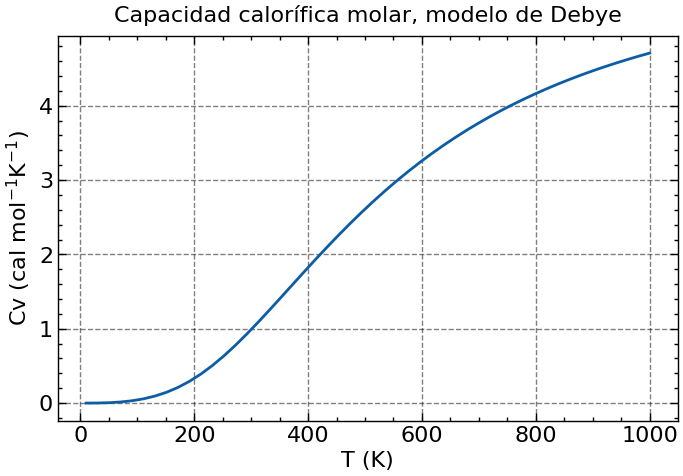

In [4]:
# Cálculo de capacidad calorífica
def f(x, a):
    return x**4 * np.exp(a*x) / (np.exp(a*x) - 1) ** 2

def Cv_f(T, theta):
    return 9*R*(theta/T)**2 * quad_vec(f, 0, 1, args=(theta/T,))[0]

# Graficado
T = np.linspace(10, 1000)
plt.figure(figsize=(8, 5))
plt.plot(T, Cv_f(T, theta))
plt.title('Capacidad calorífica molar, modelo de Debye', pad=10)
plt.xlabel('T (K)')
plt.ylabel(r'Cv (cal mol$^{-1}$K$^{-1}$)')

### APARTADO 3

Para comparar resultados experimentales y teóricos, representémoslos juntos. Marquemos también como referencia la temperatura ambiente, que se puede suponer de unos $\sim20^\circ\mathrm{C}$.

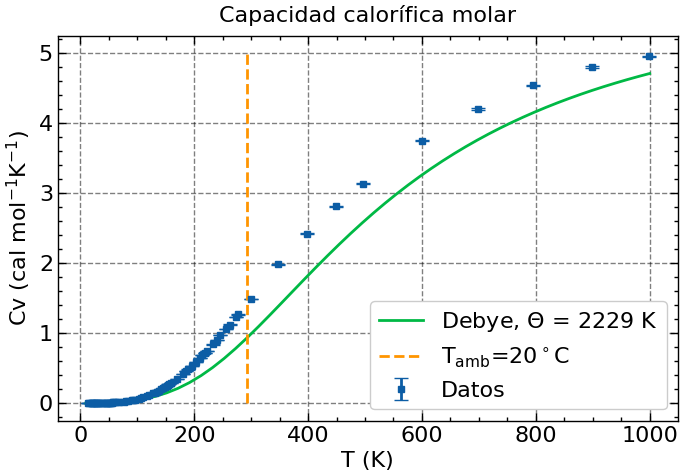

In [5]:
T = np.linspace(10, 1000)
plt.figure(figsize=(8, 5))
plt.errorbar(datos.Temp, datos.Cv, yerr=DCv, fmt='s', ms=4, capsize=5, label='Datos')
plt.plot(T, Cv_f(T, theta), label=f'Debye, $\Theta$ = {theta:.0f} K')
plt.plot([293, 293], [0, 5], '--', label='T$_{\mathrm{amb}}$=20$^\circ$C')
plt.title('Capacidad calorífica molar', pad=10)
plt.xlabel('T (K)')
plt.ylabel(r'Cv (cal mol$^{-1}$K$^{-1}$)')
plt.legend()

Podemos comprobar que el ajuste, efectivamente, no es particularmente bueno a temperaturas por encima de ambiente (incluso a temperaturas menores, en torno a $200\ \mathrm{K}$, ya muestra discrepancias significativas con los datos experimentales). Veamos entonces si el modelo de Debye puede seguirse empleando a altas temperaturas. Ajustamos los datos experimentales al modelo de Debye por el algoritmo de Levenberg Marquardt, empleando como estimación del parámetro óptimo de ajuste la $\Theta$ previamente calculada.

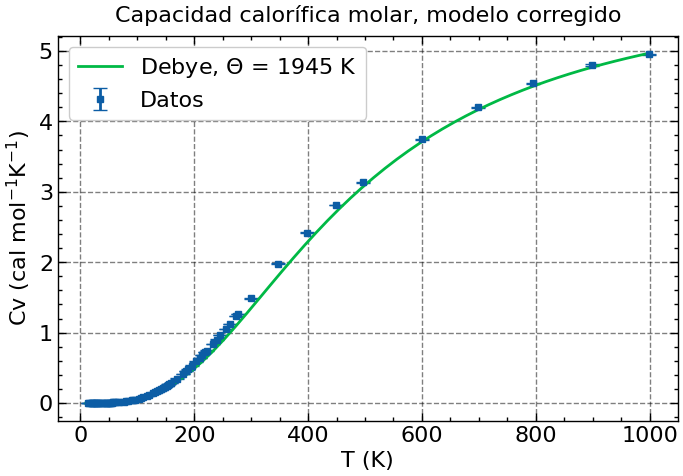

In [6]:
# Ajuste
popt, pcov = curve_fit(Cv_f, datos.Temp, datos.Cv, p0=theta, sigma=DCv, absolute_sigma=True)

# Graficado
T = np.linspace(10, 1000)
plt.figure(figsize=(8, 5))
plt.errorbar(datos.Temp, datos.Cv, yerr=DCv, fmt='s', ms=4, capsize=5, label='Datos')
plt.plot(T, Cv_f(T, popt), label=f'Debye, $\Theta$ = {popt[0]:.0f} K')
plt.title('Capacidad calorífica molar, modelo corregido', pad=10)
plt.xlabel('T (K)')
plt.ylabel(r'Cv (cal mol$^{-1}$K$^{-1}$)')
plt.legend()

Observamos ahora un buen acuerdo entre los datos experimentales y el modelo teórico. Sin embargo, la temperatura de Debye calculada por este método es un $13\%$ menor que la obtenida por ajuste lineal. 

Según J.E. Desnoyers y J.A. Morrison (1958) existe una dependencia suave $\Theta-T$ si ajustamos los datos al modelo de Debye. En su Figura 1 se observa cómo $\Theta(T=0\ \mathrm{K})\gtrsim2200\ \mathrm{K}$ y la temperatura de Debye aparente decae con $T$. Al tener mayor precisión en el cálculo de $C_v$ que experimentos anteriores, son capaces de obtener esta curva suave. Podemos intentar calcular $\Theta^\star$, tal que $C_v^{Debye}(T^{datos}, \Theta^\star)-C_v^{datos}$ sea mínimo, en un rango mayor de temperaturas que Desnoyers y Morrison para tener mejor perspectiva.

Text(0, 0.5, '$\\Theta$ (K)')

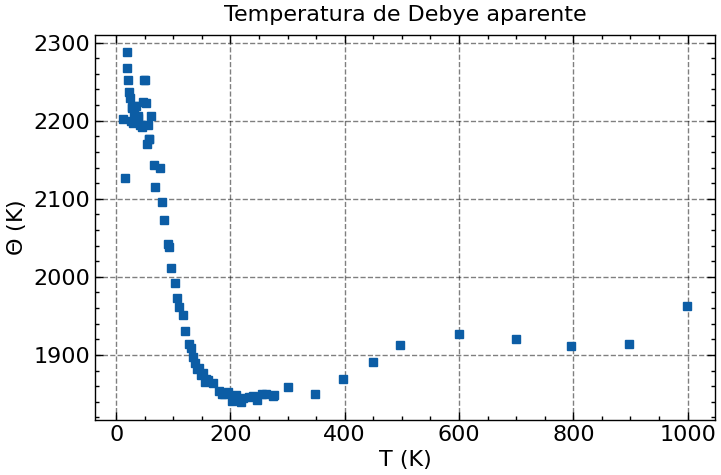

In [7]:
# Minimización
@np.vectorize
def theta_app(T, Cv):
    func = lambda theta: Cv_f(T, theta) - Cv
    return fsolve(func, theta)[0]

# Graficado
plt.figure(figsize=(8, 5))
plt.plot(datos.Temp, theta_app(datos.Temp, datos.Cv), 's')
plt.title('Temperatura de Debye aparente', pad=10)
plt.xlabel('T (K)')
plt.ylabel('$\Theta$ (K)')

He aquí el problema. Mientras que la temperatura de Debye aparente a $0\ \mathrm{K}$ ronda los $\sim2250\ \mathrm{K}$, a temperaturas de unos $\sim200\ \mathrm{K}$, régimen en el que más datos se han recogido, ronda los $\sim1850\ \mathrm{K}$, y a mayor temperatura, ronda los $\sim1950\ \mathrm{K}$. Estas temperaturas son consistentes con los valores ajustados de $\Theta$ a baja y alta temperatura.